In [346]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [347]:
pil_image = Image.open('./imgs/I.png')
pil_image.size
edge_size = pil_image.size[0]

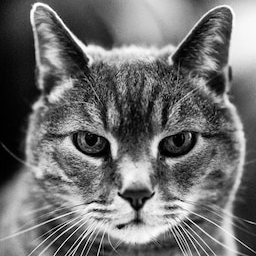

<BarContainer object of 256 artists>

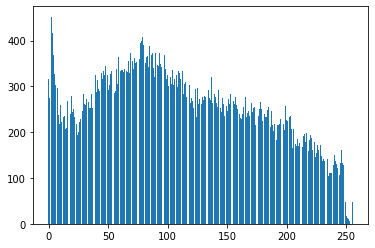

In [348]:
display(pil_image)
plt.bar(range(edge_size), height=pil_image.histogram())

In [349]:
def create_harmonic_noise(f, mu=0.1, sigma=0.05):
    r = np.ndarray(shape=(edge_size, edge_size))
    A = np.random.standard_normal(edge_size) * sigma + mu
    phi = np.random.uniform(low=0, high=2 * np.pi)
    for i in range(edge_size):
        # create phi_i ~ Uniform([0, 2pi])
        # create A_i ~ Normal(mu=0.1, sigma=0.05)
        for j in range(edge_size):
            r[i, j] = A[i] * np.cos(2 * np.pi * f * j + phi)
    return r

In [350]:
def merge_image_with_noise(im, r):
    def max_value(x):
        if x < 0:
            return 0
        elif x > 255:
            return 255
        else:
            return x
    arr = np.array(im) / edge_size
    arr += r
    arr *= 256
    arr = np.vectorize(max_value)(arr)
    arr = np.array(arr, dtype=np.uint8)
    return arr

In [351]:
f1 = 1/8
f2 = 1/32
sigma = 0.05
mu = 0.1

r1 = create_harmonic_noise(f1, mu, sigma)
r2 = create_harmonic_noise(f2, mu, sigma)
r12 = (r1 + r2) / 2

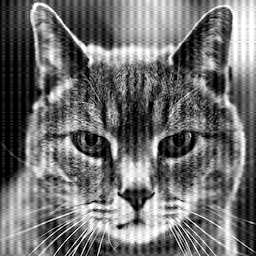

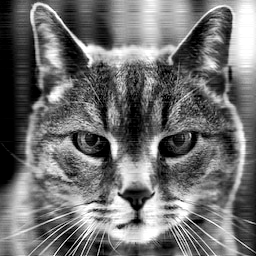

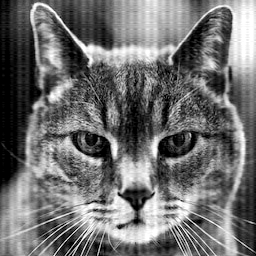

In [352]:
orig_image = pil_image.copy()

arr_0 = np.array(orig_image)
arr_1 = merge_image_with_noise(orig_image, r1)
arr_2 = merge_image_with_noise(orig_image, r2)
arr_12 = merge_image_with_noise(orig_image, r12)

image_1 = Image.fromarray(arr_1)
image_2 = Image.fromarray(arr_2)
image_12 = Image.fromarray(arr_12)
display(image_1)
display(image_2)
display(image_12)

## Subclause d

In [353]:
def calc_dft(im, inverse=False):
    """ 
    Calculate the dft matrix of an image (ndarray)
    Calculated by multiplying the rotated array and DFT matrix - as getting DFT for each row.
    """
    edge_size = im.shape[1]
    dft_mat = np.empty(shape=(edge_size, edge_size), dtype=complex)
    inverse_factor = -1 if not inverse else 1
    omega = np.exp(inverse_factor * 2j * np.pi / edge_size)
    for i in range(edge_size):
        for j in range(edge_size):
            dft_mat[i,j] = np.power(omega, i * j, dtype=complex)
    return np.transpose(dft_mat @ im.T) / np.sqrt(edge_size)

In [354]:
dft_0 = calc_dft(arr_0) / 255
dft_1 = calc_dft(arr_1) / 255
dft_2 = calc_dft(arr_2) / 255
dft_12 = calc_dft(arr_12) / 255

In [355]:
dfts = [dft_0, dft_1, dft_2, dft_12]
dft_real = [np.real(im) for im in dfts]
dft_imag = [np.imag(im) for im in dfts]

In [356]:
def recon_image(im, f):
    edge_size = im.shape[1]
    recon = im.copy() # np.empty(shape=(edge_size, edge_size))
    for i in range(edge_size):
        for j in range(edge_size):
            if j % (1/f) == 0:
                recon[i][j] = 0
    return recon

In [359]:
recon_1 = Image.fromarray(recon_image(arr_1, 1/8))
recon_2 = Image.fromarray(recon_image(arr_2, 1/32))
recon_12_1 = Image.fromarray(recon_image(np.array(recon_2), 0.125)) # file recon_12_1
recon_12_2 = Image.fromarray(recon_image(np.array(recon_1), 1/32)) # file recon_12_2
recons = [recon_1, recon_2, recon_12_1, recon_12_2]

In [360]:
recon_mse_list = [((arr_0 - recon)**2).mean() for recon in recons]
print(f'{recon_mse_list=}')

noisy_imgs = [arr_1, arr_2, arr_12]
noise_mse_list = [((arr_0 - img)**2).mean() for img in noisy_imgs]
print(f'{noise_mse_list=}')

recon_mse_list=[78.01725769042969, 89.54061889648438, 89.79695129394531, 78.01725769042969]
noise_mse_list=[77.17283630371094, 89.27334594726562, 75.85113525390625]
